In [21]:
import pandas as pd
import seaborn as sns
sns.set_context('poster')

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


//anaconda/envs/my_insight_env/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['std', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from current_application import get_sql_dataset, prepare_dataset, run_model, add_ab_info
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

//anaconda/envs/my_insight_env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Get dataset and prepare it for running through a model

In [3]:
all_features, cdiff_data, outcomes = get_sql_dataset.main()

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have outcomes of length: 39429
Flag value counts: False    38049
True      1380
Name: cdiff, dtype: int64
Adjusted data values for age, admission time
Removed outliers for height and weight
Log-transformed values for bands, bilirubin, bun, creatinine, glucose, lactate, inr, and wbc
Merged hospital stays within 90 days, now have outcomes: 35268
Flag value counts: False    34016
True      1252
Name: cdiff, dtype: int64
Removed young patients, now have outcomes: 32092
Flag value counts: False    30840
True      1252
Name: cdiff, dtype: int64
Removed admits for cdiff, now have outcomes: 32000
Flag value counts: False    30840
True      1160
Name: cdiff, dtype: int64
Combined features with outcomes, now have data of length: 31331
Flag value counts: 0    30189
1     1142
Name: outcome, dtype: int64


In [102]:
ab_data = add_ab_info.main(cdiff_data)

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have antibiotic df of length: 73317
Determined drug groups, number of groups: 31699
Encoded classes are: ['Aminoglycoside' 'Antifungal' 'Carbapenem' 'Cephalosporin' 'Combination'
 'Fluoroquinolone' 'Glycopeptide' 'Lincosamide' 'Macrolide' 'Metronidazole'
 'None' 'Other' 'Penicillin BS' 'Penicillin NS' 'Polypeptide' 'Rifamycin'
 'Sulfonamide' 'TB-specific' 'Tetracycline']


In [6]:
x_train, y_train, test_set = prepare_dataset.main(cdiff_data, only_ab=False, 
                                                  add_ab=True, multioutcome=False)

Selected features and dropped low-feature rows, now have dataset of length: 31319
Flag value counts: 0    30177
1     1142
Name: outcome, dtype: int64
Balanced dataset by undersampling dominant class, now have dataset of length: 2284
Flag value counts: 1    1142
0    1142
Name: outcome, dtype: int64


In [7]:
list(x_train.columns)

['aniongap',
 'albumin',
 'log_bands',
 'bicarbonate',
 'log_bilirubin',
 'log_bun',
 'log_creatinine',
 'chloride',
 'log_glucose',
 'hemoglobin',
 'log_lactate',
 'platelet',
 'potassium',
 'log_inr',
 'sodium',
 'log_wbc',
 'heartrate_mean',
 'sysbp_mean',
 'diasbp_mean',
 'meanbp_mean',
 'resprate_mean',
 'tempc_mean',
 'spo2_mean_3',
 'weight',
 'bmi',
 'age',
 'rescaled_time',
 'Aminoglycoside',
 'Antifungal',
 'Carbapenem',
 'Cephalosporin',
 'Combination',
 'Fluoroquinolone',
 'Glycopeptide',
 'Lincosamide',
 'Macrolide',
 'Metronidazole',
 'None',
 'Other',
 'Penicillin BS',
 'Sulfonamide',
 'gender',
 'am_admit',
 'admission_type_ELECTIVE',
 'admission_type_EMERGENCY',
 'admission_location_EMERGENCY ROOM ADMIT',
 'admission_location_REFERRAL',
 'admission_location_TRANSFER',
 'ethnicity_WHITE',
 'ethnicity_BLACK',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_statu

In [8]:
x_vals = x_train.drop(['hadm_id'], axis=1)  #, 'expire'
prefix = 'mon_feat_ab'
test_set.to_csv('/Users/nwespe/Desktop/test_set_' + prefix + '.csv')

<a list of 0 Text xticklabel objects>


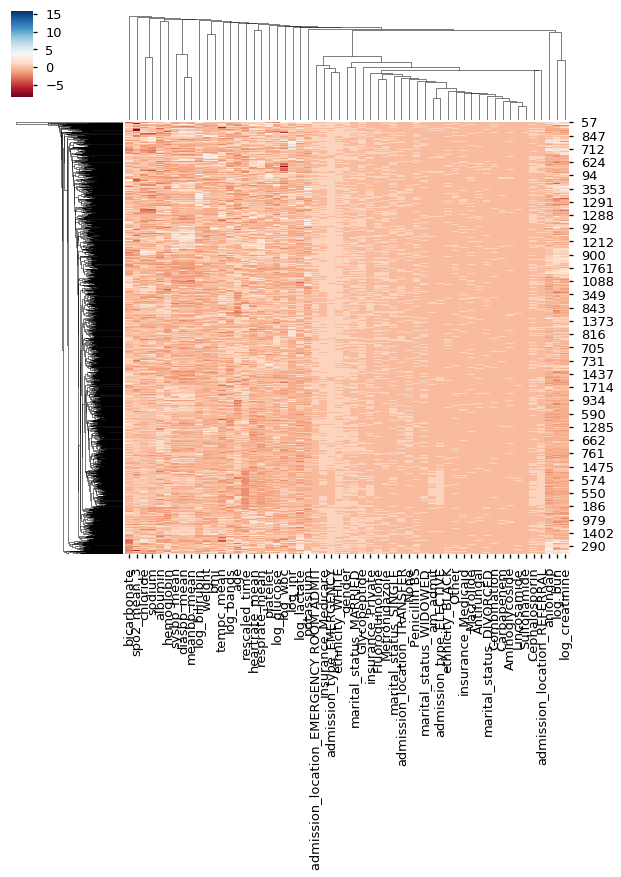

In [125]:
fig = plt.figure(figsize=(24, 24))
g = sns.clustermap(x_vals, cmap='RdBu', xticklabels=1)
locs, labels = plt.xticks()
print labels

First fit data with a logistic regression

Accuracy: 0.644772851669
Classification report: 
             precision    recall  f1-score   support

          0       0.64      0.66      0.65       913
          1       0.65      0.63      0.64       914

avg / total       0.64      0.64      0.64      1827

Confusion matrix results: 
[[603 310]
 [339 575]]
False positives: 310
False negatives: 339


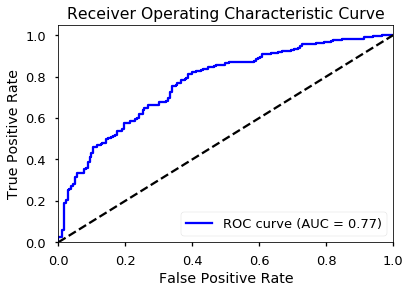

In [9]:
prefix = 'logistic_both_mon'
log_model = run_model.fit_model(x_train, y_train, model='logistic', save=False)
run_model.evaluate_model(x_train, y_train, log_model)
run_model.plot_roc_curve(log_model, x_train, y_train, save=True, prefix=prefix)

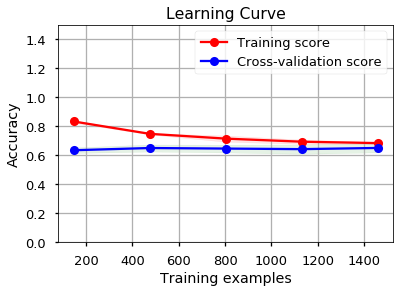

In [73]:
run_model.plot_learning_curve(log_model, x_train, y_train, save=True, prefix=prefix)

In [10]:
coefs = np.around(log_model.coef_, 3)
coefs.reshape(-1)
std = x_vals.std(axis=0)
std_coef_series = pd.Series(np.reshape(np.array(std)*coefs, -1), index=std.index)
featimp_df = pd.DataFrame(data=[std, std_coef_series])
model_feature_importance = featimp_df.loc[1].abs().sort_values(ascending=False) #
model_feature_importance[:10]

Metronidazole                              0.395101
albumin                                    0.249068
insurance_Medicare                         0.237794
heartrate_mean                             0.214059
aniongap                                   0.210057
admission_location_REFERRAL                0.183021
resprate_mean                              0.179049
Glycopeptide                               0.174531
admission_location_EMERGENCY ROOM ADMIT    0.154619
log_lactate                                0.154042
Name: 1, dtype: float64

Use a Random Forest classifier with default settings (n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, warm_start=False, class_weight=None)

Accuracy: 0.627257799672
Classification report: 
             precision    recall  f1-score   support

          0       0.61      0.70      0.65       913
          1       0.65      0.55      0.60       914

avg / total       0.63      0.63      0.63      1827

Confusion matrix results: 
[[641 272]
 [409 505]]
False positives: 272
False negatives: 409


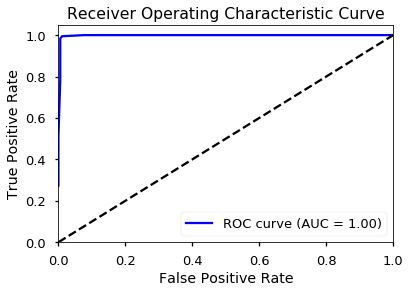

In [156]:
rf_model = RandomForestClassifier()
rf_model.fit(x_vals, y_train)

prefix = 'rf_default_both_mon'
run_model.evaluate_model(x_train, y_train, rf_model)
run_model.plot_roc_curve(rf_model, x_train, y_train, save=True, prefix=prefix)

Use a Grid Search to optimize parameters for Random Forest

In [11]:
n_features = x_vals.shape[1]
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {"n_estimators": [100, 500, 1000, 1500],
              #'max_features': ['sqrt', 0.5],
              "max_depth": [4, 10, None],
              "min_samples_leaf": [1, 3, 10]
             }

search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='recall', cv=5)
search.fit(x_vals, y_train)
search.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}

In [12]:
search_results = pd.DataFrame(search.cv_results_)
search_results.sort_values('rank_test_score')[:5]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_leaf,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
25,1.974678,0.219430,0.676136,1.000000,None,1,500,"{u'n_estimators': 500, u'max_depth': None, u'm...",1,0.726776,...,0.639344,1.000000,0.699454,1.000000,0.659341,1.000000,0.073021,0.006286,0.032141,0.000000
32,0.517516,0.144124,0.676136,0.873634,None,10,100,"{u'n_estimators': 100, u'max_depth': None, u'm...",1,0.688525,...,0.622951,0.875513,0.699454,0.874145,0.681319,0.868852,0.081259,0.019904,0.027242,0.002468
35,5.553380,0.553896,0.675053,0.883754,None,10,1500,"{u'n_estimators': 1500, u'max_depth': None, u'...",3,0.726776,...,0.622951,0.880985,0.677596,0.883721,0.675824,0.878415,0.191691,0.038904,0.032907,0.003823
29,1.859841,0.231891,0.675041,0.993436,None,3,500,"{u'n_estimators': 500, u'max_depth': None, u'm...",4,0.732240,...,0.606557,0.991792,0.699454,0.994528,0.664835,0.993169,0.050039,0.019200,0.041671,0.001023
34,3.709882,0.413724,0.672861,0.882933,None,10,1000,"{u'n_estimators': 1000, u'max_depth': None, u'...",5,0.732240,...,0.617486,0.878249,0.683060,0.883721,0.670330,0.881148,0.266761,0.034932,0.037012,0.003172


In [78]:
n_features = x_vals.shape[1]
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {"n_estimators": [30, 300, 1000, 1500],  #[300, 500, 700]
              "max_depth": [4, 10, None]
              #"min_samples_leaf": [5, 10]
             }

search2 = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='recall', cv=5)
search2.fit(x_vals, y_train)
search2.best_params_

{'max_depth': None, 'n_estimators': 1500}

In [79]:
search_results2 = pd.DataFrame(search2.cv_results_)
search_results2.sort_values('rank_test_score')[:4]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
11,6.013978,0.569815,0.681633,1.000000,None,1500,"{u'n_estimators': 1500, u'max_depth': None}",1,0.732240,1.000000,...,0.683060,1.000000,0.655738,1.000000,0.697802,1.000000,0.158656,0.045178,0.032524,0.000000
10,4.036718,0.358047,0.672891,1.000000,None,1000,"{u'n_estimators': 1000, u'max_depth': None}",2,0.737705,1.000000,...,0.672131,1.000000,0.628415,1.000000,0.697802,1.000000,0.189241,0.047682,0.041914,0.000000
9,1.208865,0.116073,0.671793,1.000000,None,300,"{u'n_estimators': 300, u'max_depth': None}",3,0.721311,1.000000,...,0.693989,1.000000,0.633880,1.000000,0.681319,1.000000,0.044270,0.002479,0.035667,0.000000
5,1.068823,0.126722,0.665228,0.977297,10,300,"{u'n_estimators': 300, u'max_depth': 10}",4,0.737705,0.984952,...,0.633880,0.971272,0.628415,0.969904,0.686813,0.978142,0.075192,0.004836,0.041797,0.005907


Run and evaluate the optimized RF model

In [ ]:
n_features = x_vals.shape[1]
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {"n_estimators": [1500],
              "min_samples_leaf": [1, 3, 6, 9],
             }

search3 = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='recall', cv=5)
search3.fit(x_vals, y_train)
search3.best_params_

In [ ]:
search_results3 = pd.DataFrame(search3.cv_results_)
search_results3.sort_values('rank_test_score')[:4]

Accuracy: 0.649151614669
Classification report: 
             precision    recall  f1-score   support

          0       0.66      0.63      0.64       913
          1       0.64      0.67      0.66       914

avg / total       0.65      0.65      0.65      1827

Confusion matrix results: 
[[574 339]
 [302 612]]
False positives: 339
False negatives: 302


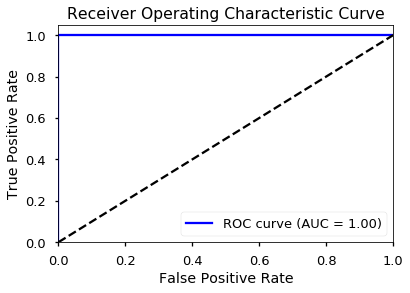

In [13]:
prefix = 'rf_optimized_both'
rf_opt = run_model.fit_model(x_train, y_train, model='rf', save=False)
run_model.evaluate_model(x_train, y_train, rf_opt)
run_model.plot_roc_curve(rf_opt, x_train, y_train, save=True, prefix=prefix)

Normalized confusion matrix
[[ 0.64  0.36]
 [ 0.31  0.69]]


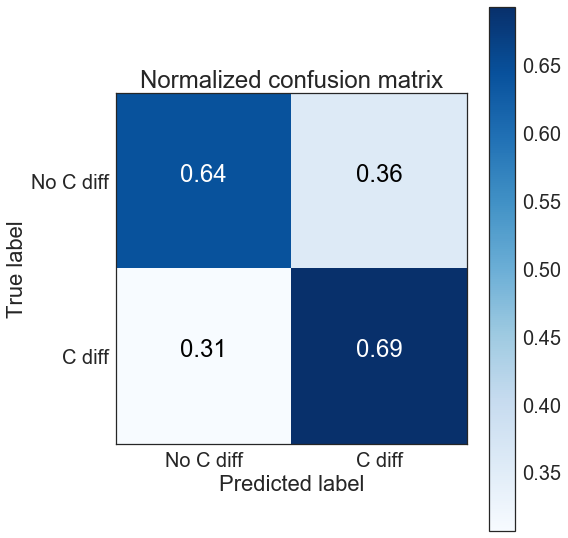

In [27]:
from sklearn.metrics import confusion_matrix
import itertools
sns.set(font_scale=2, style='white')


x_test = test_set.drop(['outcome', 'hadm_id'], axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

y_pred = rf_opt.predict(x_test)
class_names = ['No C diff', 'C diff']

# function copied from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('/Users/nwespe/Desktop/confusion_matrix.svg', bbox_inches='tight')

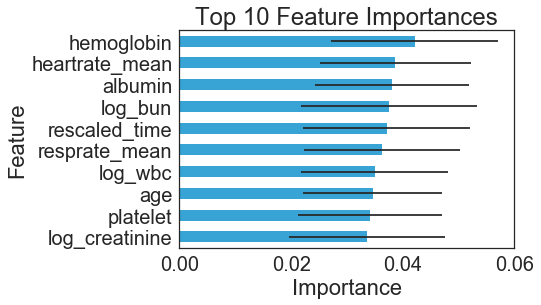

In [73]:
feature_imps = pd.DataFrame({'Feature': list(x_vals.columns), 
                             'Importance': rf_opt.feature_importances_,
                             'Std': np.std([tree.feature_importances_ for tree in rf_opt.estimators_], axis=0)})
feature_imps.sort_values(by='Importance', ascending=False, inplace=True)
feature_imps.head()

plt.figure(figsize=(10, 20))
feature_imps[:10].plot(kind='barh', x='Feature', xerr='Std', color='#38a3d5', legend=False)
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title("Top 10 Feature Importances")
plt.savefig('/Users/nwespe/Desktop/feature_importances.svg', bbox_inches='tight')

In [158]:
feature_imps = pd.DataFrame({'name': list(x_vals.columns), 'importance': rf_opt.feature_importances_})
feature_imps.sort_values('importance', ascending=False)[:10]

,importance,name
9,0.044033,hemoglobin
5,0.041699,log_bun
15,0.040642,log_wbc
1,0.038967,albumin
16,0.037126,heartrate_mean
25,0.036408,age
23,0.035790,weight
6,0.035660,log_creatinine
11,0.035432,platelet
26,0.034042,rescaled_time


In [135]:
cal_model = CalibratedClassifierCV(base_estimator=rf_opt, cv='prefit')

In [157]:
# check probabilities and calibrate
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

x_test = test_set.drop(['outcome', 'hadm_id'], axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

y_pred = rf_opt.predict(x_test)
prob_pos = rf_opt.predict_proba(x_test)[:, 1]

cal_model = CalibratedClassifierCV(base_estimator=rf_opt, cv='prefit')
y_pred2 = cal_model.predict(x_test)
prob_pos2 = cal_model.predict_proba(x_test)[:, 1]

fig = plt.figure(1, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=11)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-")

NotFittedError: This CalibratedClassifierCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

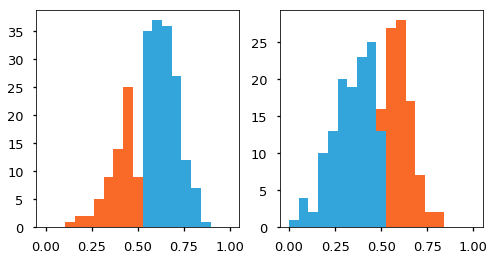

In [218]:
run_model.plot_probas(rf_opt, x_test, y_test)

(array([  1.,   4.,   2.,  10.,  13.,  20.,  19.,  23.,  25.,  13.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
         0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
         0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
         0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ]),
 <a list of 19 Patch objects>)

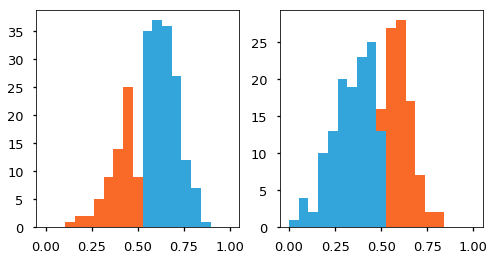

In [220]:
curr_model = rf_opt
X2 = x_test.drop('hadm_id', axis=1)
y = y_test
probs = curr_model.predict_proba(X2)
preds = curr_model.predict(X2)
prob_df = pd.DataFrame(y)
prob_df['prob_0'] = probs[:,0]
prob_df['prob_1'] = probs[:,1]
prob_df['predict'] = preds
prob_df = prob_df.join([id_col, X2])

true_pos = prob_df[(prob_df.outcome == 1) & (prob_df.predict == 1)]
true_neg = prob_df[(prob_df.outcome == 0) & (prob_df.predict == 0)]
false_pos = prob_df[(prob_df.outcome == 0) & (prob_df.predict == 1)]
false_neg = prob_df[(prob_df.outcome == 1) & (prob_df.predict == 0)]

bins = np.linspace(0, 1, 20)
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(list(true_pos.prob_1.values), color='#34A5DA', alpha=1, bins=bins)
ax[0].hist(list(false_neg.prob_1.values), color='#F96928', alpha=1, bins=bins)
ax[1].hist(list(false_pos.prob_1.values), color='#F96928', alpha=1, bins=bins)
ax[1].hist(list(true_neg.prob_1.values), color='#34A5DA', alpha=1, bins=bins)

#plt.savefig('/Users/nwespe/Desktop/' + prefix + '_train_probas.svg', bbox_inches='tight')

# Now try XGBoost

Accuracy: 0.63601532567
Classification report: 
             precision    recall  f1-score   support

          0       0.63      0.65      0.64       913
          1       0.64      0.62      0.63       914

avg / total       0.64      0.64      0.64      1827

Confusion matrix results: 
[[593 320]
 [345 569]]
False positives: 320
False negatives: 345


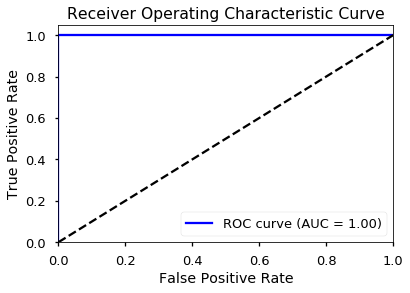

In [139]:
# test XGBoost with params from Random Forest
params = {'objective':'binary:logistic', 'n_estimators':500, 'max_depth': 10, 'seed': 42}
xgb_clf = xgb.XGBClassifier(**params)
xgb_clf.fit(x_vals, y_train)

prefix = 'xgb'
run_model.evaluate_model(x_train, y_train, xgb_clf)
run_model.plot_roc_curve(xgb_clf, x_train, y_train, save=True, prefix=prefix)

In [ ]:
# Optimize estimator number
xgdmat = xgb.DMatrix(x_train, y_train) # Create a DMatrix to make XGBoost more efficient
ind_params = {'eta': 0.06, 'seed': 42, 'objective': 'binary:logistic'}  # 'subsample': 0.8, 'colsample_bytree': 0.8, 'eta': 0.1,  

cv_xgb = xgb.cv(params = ind_params, dtrain = xgdmat, num_boost_round = 2000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [ ]:
cv_xgb.tail(5)

In [ ]:
ind_params = {'learning_rate': 0.06, 'seed': 42, 'objective': 'binary:logistic', 'n_estimators': 100}
cv_params = {'max_depth': [6],
             'min_child_weight': [1]
            }

xgb_opt = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, scoring='recall', cv=5, n_jobs=-1) 
xgb_opt.fit(x_vals, y_train)

In [ ]:
xgb_opt.best_params_, xgb_opt.best_score_

In [ ]:
xgb_opt_results = pd.DataFrame(xgb_opt.cv_results_)
xgb_opt_results.sort_values('rank_test_score')[:5] #[(search_results['param_max_depth'] == 10) & (search_results['param_max_features'] == 'log2')]

In [ ]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 4} 
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 48)

In [ ]:
xgb.plot_importance(final_gb)

In [ ]:
importances = final_gb.get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by='Importance', inplace=True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

Check the best model on the test set

Accuracy: 0.634573304158
Classification report: 
             precision    recall  f1-score   support

          0       0.64      0.63      0.63       229
          1       0.63      0.64      0.64       228

avg / total       0.63      0.63      0.63       457

Confusion matrix results: 
[[144  85]
 [ 82 146]]
False positives: 85
False negatives: 82


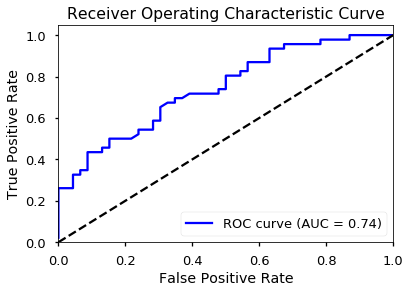

In [250]:
curr_model = rf_opt

x_test = test_set.drop('outcome', axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

run_model.evaluate_model(x_test, y_test, curr_model)
run_model.plot_roc_curve(curr_model, x_test, y_test, save=True, prefix=prefix)

In [242]:
risk, results = run_model.eval_risk(rf_opt)

In [234]:
results['Probability'] = results['Probability'].apply(lambda x: "{{:{}%}}".format('0.1').format(x))

In [245]:
risk, results

('moderate',                 Probability
 Metronidazole         73.7%
 Glycopeptide          71.1%
 Sulfonamide           67.8%
 Penicillin BS         67.5%
 Combination           67.4%
 Aminoglycoside        67.1%
 Carbapenem            67.1%
 Macrolide             66.9%
 Antifungal            66.9%
 Fluoroquinolone       66.6%
 Cephalosporin         66.4%
 Other                 66.2%
 None                  65.9%
 Lincosamide           64.6%)

In [183]:
ab_profile.iloc[:, 27:41]

,Aminoglycoside,Antifungal,Carbapenem,Cephalosporin,Combination,Fluoroquinolone,Glycopeptide,Lincosamide,Macrolide,Metronidazole,None,Other,Penicillin BS,Sulfonamide
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(rf_opt, open(filename, 'wb'))

# Plot raw data

In [ ]:
bal_data = prepare_dataset.balance_dataset(cdiff_data, 'outcome')

In [ ]:
get_sql_dataset.plot_feature_counts(cdiff_data)

In [ ]:
get_sql_dataset.plot_probability_quantiles(cdiff_data, save=True)

In [ ]:
get_sql_dataset.plot_correlations(cdiff_data)

In [ ]:
get_sql_dataset.plot_features(cdiff_data, save=True)